In [23]:
import os
import csv
import pandas as pd
import numpy as np

import datetime
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import squarify

from sklearn import model_selection, preprocessing, metrics
plt.style.use('fivethirtyeight')

print(os.getcwd())
print(os.listdir("../"))

/kaggle/working
['input', 'lib', 'working', 'config']


In [24]:
def create_csv_file(txt_file, csv_file):
    """
    converts a text file into csv_file.
    function expects the column values and given starting expression in text for its identification to be "same".
    """
    with open(txt_file,"r") as input_file, open(csv_file, "w") as csv_file:
        column = {"PaperTitle":"", "Authors":"", "Year":"","Publication_Venue":"", "Index_Id":"", "References_Id":"","Abstract":""}
        writer = csv.writer(csv_file)
        writer.writerow(column.keys())
        for l in input_file.readlines():
            l = l.strip()
            if l.startswith("#*"):
                column["PaperTitle"] = l[2:]
            elif l.startswith("#@"):
                column["Authors"] = l[2:]
            elif l.startswith("#t"):
                column["Year"] = l[2:]
            elif l.startswith("#c"):
                column["Publication_Venue"] = l[2:]
            elif l.startswith("#index"):
                column["Index_Id"] = l[6:]
            elif l.startswith("#%"):
                references = column.get("References_Id","")
                references += ":" + l[2:]
                column["References_Id"] = references
            elif l.startswith("#!"):
                column["Abstract"] = l[2:]
            elif l == "":
                writer.writerow(column.values())
                column = {"PaperTitle":"", "Authors":"", "Year":"","Publication_Venue":"", "Index_Id":"", "References_Id":"","Abstract":""}
            else:
                print("dump of invalid data for {}:{}".format(column["PaperTitle"],l))

In [25]:
# CSV CONVERSION NOT NEEDED AS CSV FILE IS LOADED HERE
# txt_file = "../acm.txt"
# csv_file = "../acm.csv"
# create_csv_file(txt_file, csv_file)

In [28]:
# CSV CONVERSION NOT NEEDED AS CSV FILE IS LOADED HERE
# txt_file = "../dblp.txt"
# csv_file = "../dblp.csv"
# create_csv_file(txt_file, csv_file)

In [29]:
#load dataframe from csv
%timeit
df = pd.read_csv("../input/acm.csv")

In [ ]:
#DBLP indexid
# %timeit
# df2 = pd.read_csv("../dblp.csv")

In [ ]:
# df2.info()

sample dataset

In [ ]:
# df2.head()

In [30]:
df.head()

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract
0,MOSFET table look-up models for circuit simula...,NaN,1984.0,"Integration, the VLSI Journal",1,NaN,NaN
1,The verification of the protection mechanisms ...,Virgil D. Gligor,1984.0,International Journal of Parallel Programming,2,NaN,NaN
2,Another view of functional and multivalued dep...,"M. Gyssens, J. Paredaens",1984.0,International Journal of Parallel Programming,3,NaN,NaN
3,Entity-relationship diagrams which are in BCNF,"Sushil Jajodia, Peter A. Ng, Frederick N. Spri...",1984.0,International Journal of Parallel Programming,4,NaN,NaN
4,The computer comes of age,Rene Moreau,1984.0,The computer comes of age,5,NaN,NaN


In [ ]:
###### TODO1: check if there are common "research papers" in DBLP and ACM dataset 
###### TODO2: combine the 2 datasets (indexid's format is different)

***count_reference*** represents the number of times particular paper got referred in our dataset

In [31]:
df["count_reference"] = 0

####YEAR

In [32]:
df["Year"] = df["Year"].fillna(0)
df["Year"] = df["Year"].astype(int)

**Rows with NaN year**

In [ ]:
df[df["Year"] == 0].shape

***Year of publication distribution in the data***

In [ ]:
ydf = df[df["Year"]!=0]
plt.figure(figsize=(8,6))
plt.scatter(range(ydf.shape[0]), np.sort(ydf["Year"].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.title("Year Distribution", fontsize=20) 
plt.show()

In [64]:
df.isna().sum()

PaperTitle                46
Authors               151075
Year                       0
Publication_Venue        139
Index_Id                   0
References_Id        1344739
Abstract              713788
count_reference            0
dtype: int64

In [ ]:
###### TODO3: DATA-CLEAN

In [ ]:
print(df.dtypes)

In [ ]:
df["Index_Id"].unique()
print(any(df['Index_Id'].duplicated())) 
print(len(df['Index_Id'].unique()))
print(len(df.index))

> Index_Id = 2381731 is duplicated 9 times , It points to 7 different papers and has 82080 references.

In [ ]:
df[df.duplicated(subset="Index_Id")]

In [ ]:
df.Index_Id.describe()

In [33]:
reference_count = {}
for references in df[df["References_Id"].notnull()]["References_Id"]:
    ref_list = map(int,references.strip(":").split(":"))
    for ref in ref_list:
        if ref in reference_count:
            reference_count[ref] += 1
        else:
            reference_count[ref] = 1
print(reference_count[2381731])

82080


In [34]:
def update_ref_count(row):
    if row['Index_Id'] in reference_count:
        return reference_count[row['Index_Id']]
    else:
        return 0
df["count_reference"] = df.apply(lambda row: update_ref_count(row),axis=1)

In [ ]:
print(df.head(5))

In [ ]:
sorted_by_value = sorted(reference_count.items(), key=lambda kv: kv[1],reverse=True)
print(sorted_by_value[:10])
print([row[0] for row in sorted_by_value[:10]])
print([row[1] for row in sorted_by_value[:10]])

In [ ]:
x_values = [row[0] for row in sorted_by_value[:10]]
y_values = [row[1] for row in sorted_by_value[:10]]
x_pos = np.arange(len(x_values))
plt.figure(figsize=(13,7))
plt.bar(x_pos,y_values, align='center', alpha=1)
plt.xticks(x_pos,x_values)
plt.ylabel('reference count')
plt.title('Top 10 paper by reference')
 
plt.show()

In [ ]:
df["Authors"] = df["Authors"].fillna('')
print(any(df["Authors"].isna()))
df[df['Authors'].str.contains('-')]

In [ ]:
print(df["Authors"].shape)
print(df[df['Authors'].str.isalpha()].shape)

In [ ]:
df[df['Authors'].str.isalpha()]

In [ ]:
df2 = df.filter(regex='spike')

In [ ]:
df[df["Index_Id"].isin(inlink[2135000])].shape

Above paper is referenced by 9770 other papers

In [35]:
inlink = {}
outlink = {}
#Test for smaller set
testset_len = 10000
for _t, row in df[df["References_Id"].notnull()].iterrows():
    ref = row["References_Id"]
    index = row["Index_Id"]
    ref_list = list(map(int,ref.strip(":").split(":")))
    outlink[index] = ref_list
    for r in ref_list:
        inlist = inlink.get(r,[])
        inlist.append(index)
        inlink[r] = inlist
    #Test for smaller set
    testset_len -= 1
    if not testset_len:
        testset_len = 10000
        break

In [36]:
#Test for smaller set
#pagerank = { row["Index_Id"]:1 for _t, row in df[:testset_len].iterrows()}
#complete set
pagerank = { row["Index_Id"]:1 for _t, row in df.iterrows()}

In [62]:
def create_pagerank(theta, pagerank,page_year, inlink, outlink):
    updated_pagerank = {}
    iterations = 0
    year_citation_count = { page_year[index]:0 for index in page_year}
    year_paper_count = { page_year[index]:0 for index in page_year}
    avg_year_citation_count = {}
    for index in page_year:
        year = page_year[index]
        len_outlink = len(outlink.get(index, []))
        if len_outlink > 0:
            year_citation_count[year] += len_outlink
            year_paper_count[year] += 1
    for year in year_citation_count:
        if year_paper_count[year] > 0:
            avg_year_citation_count[year] = year_citation_count[year]/year_paper_count[year]
    while True:
        flag = True
        for index_id, current_score in pagerank.items():
            if index_id in inlink:
                inlink_list = inlink[index_id]
                new_score = 0.0
                for link in inlink_list:
                    len_outlink = len(outlink.get(link, []))
                    if link in pagerank:
                        new_score += pagerank[link]/len_outlink
                new_score = (1.0 - theta) + float(theta)**new_score
                #new_score = (1.0 - theta) + float(theta)**(new_score/avg_year_citation_count[page_year[index_id]])
                if current_score != new_score:
                    flag = False
                updated_pagerank[index_id] = new_score
        iterations += 1
        if flag == True:
            break
        pagerank = updated_pagerank
        del updated_pagerank
        updated_pagerank = {}
    print(f"number of iterations:{iterations}")
    #normalize the score
    max_score = max(pagerank.values())
    print(f"max score is {max_score}")
    pagerank = { index:score/max_score for index, score in pagerank.items()}

In [63]:
theta = 0.85
page_year = {row["Index_Id"]:row["Year"] for _t, row in df.iterrows()}
create_pagerank(theta, pagerank, page_year, inlink, outlink)

number of iterations:16
max score is 1.15


In [65]:
df.shape

(2385066, 8)

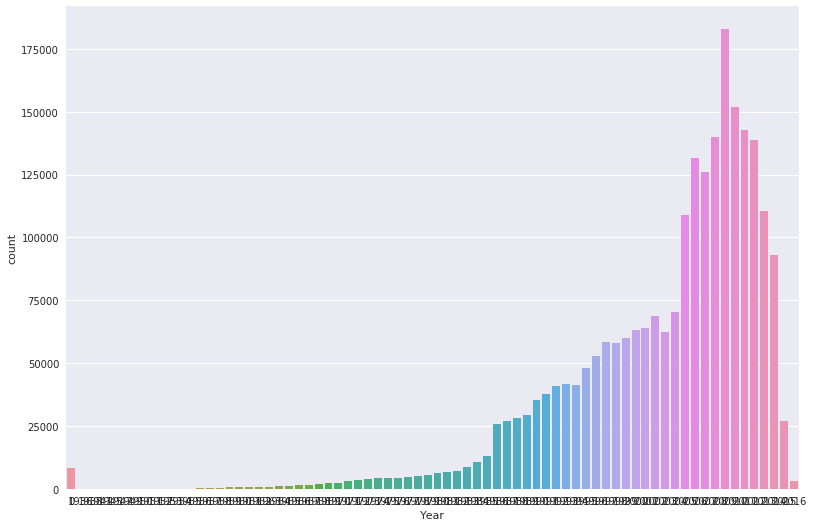

In [67]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="darkgrid")
ax = sns.countplot(x="Year", data=df)

In [60]:
    year_citation_count = { page_year[index]:0 for index in page_year}
    year_paper_count = { page_year[index]:0 for index in page_year}
    avg_year_citation_count = {}
    for index in page_year:
        year = page_year[index]
        len_outlink = len(outlink.get(index, []))
        if len_outlink > 0:
            year_citation_count[year] += len_outlink
            year_paper_count[year] += 1
    for year in year_citation_count:
        if year_paper_count[year] > 0:
            avg_year_citation_count[year] = year_citation_count[year]/year_paper_count[year]

In [61]:
print(year_citation_count)

{1984: 1126, 1983: 158, 1982: 19, 1981: 0, 1985: 3093, 2000: 423, 1986: 8909, 1979: 0, 1977: 0, 1987: 14225, 1978: 0, 1996: 0, 1976: 0, 1988: 18635, 1969: 0, 1980: 0, 1957: 0, 1989: 22705, 1999: 0, 1990: 5125, 1998: 0, 1971: 0, 1992: 0, 1991: 0, 1993: 0, 1994: 0, 1995: 0, 1970: 0, 1972: 0, 2010: 0, 2011: 0, 0: 0, 1997: 0, 2013: 0, 1954: 0, 1955: 0, 1956: 0, 1958: 0, 1959: 0, 1960: 0, 1961: 0, 1962: 0, 1963: 0, 1964: 0, 1965: 0, 1966: 0, 1967: 0, 1968: 0, 1973: 0, 1974: 0, 1975: 0, 2001: 0, 2002: 0, 2009: 0, 2003: 0, 2012: 0, 2004: 0, 1952: 0, 2005: 0, 1951: 0, 1941: 0, 1953: 0, 1950: 0, 1947: 0, 1949: 0, 1936: 0, 2008: 0, 2006: 0, 2007: 0, 1938: 0, 1945: 0, 2014: 0, 2015: 0, 2016: 0}


In [ ]:
#TODO: Citation data is not in link with the papers published. Need to clean this to get better score on time-data independency.

In [ ]:
len(set(pagerank.keys()))
del inlink
del outlink

In [ ]:
def update_rank(row):
    if row["Index_Id"] in page_rank:
        return page_rank[row["Index_Id"]]
    else:
        return 0

In [ ]:
df["page_rank"] = 0
df["page_rank"] = df.apply(lambda row: update_rank(row),axis = 1)
df.to_csv("ranked_acm_1.csv")